In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import signal
from scipy.stats import spearmanr
import warnings
# 禁用所有警告
warnings.filterwarnings("ignore")
import os
import sys
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from arch import arch_model
import matplotlib as mpl
from statsmodels.stats.diagnostic import acorr_ljungbox #白噪声检验
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error
#######读取数据等
from statsmodels.tsa.stattools import adfuller


In [2]:
anthophyllum=pd.read_excel("C:/Users/韩甄泽/OneDrive/桌面/2023年秋数据科学导论大作业/附件3_项目三数据集/merged_data_pl1_huaye.xlsx")
cauliflower=pd.read_excel("C:/Users/韩甄泽/OneDrive/桌面/2023年秋数据科学导论大作业/附件3_项目三数据集/merged_data_pl2_huacai.xlsx")
tubers=pd.read_excel("C:/Users/韩甄泽/OneDrive/桌面/2023年秋数据科学导论大作业/附件3_项目三数据集/merged_data_pl3_ssgj.xlsx")
eggplant=pd.read_excel("C:/Users/韩甄泽/OneDrive/桌面/2023年秋数据科学导论大作业/附件3_项目三数据集/merged_data_pl4_qie.xlsx")
capsicum=pd.read_excel("C:/Users/韩甄泽/OneDrive/桌面/2023年秋数据科学导论大作业/附件3_项目三数据集/merged_data_pl5_lajiao.xlsx")
mushroom=pd.read_excel("C:/Users/韩甄泽/OneDrive/桌面/2023年秋数据科学导论大作业/附件3_项目三数据集/merged_data_pl6_shiyongjun.xlsx")

In [5]:
# 设置使用中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 请替换为你系统中的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 显示负号
from scipy.stats import norm


NormaltestResult(statistic=795.7316819075254, pvalue=1.6183063415903978e-173)


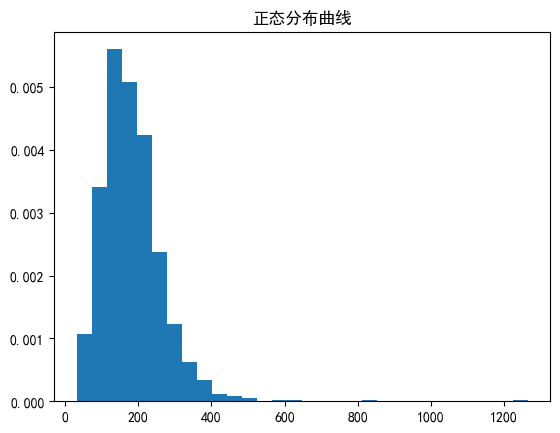

NormaltestResult(statistic=345.02222022314277, pvalue=1.200540489109384e-75)


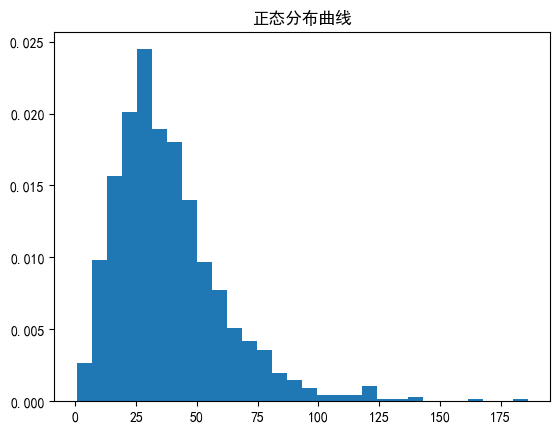

NormaltestResult(statistic=640.56538623808, pvalue=7.998227064058055e-140)


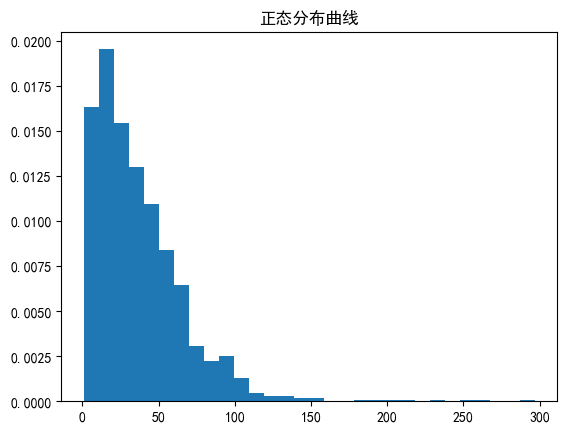

NormaltestResult(statistic=406.2839972967302, pvalue=5.9779316374367946e-89)


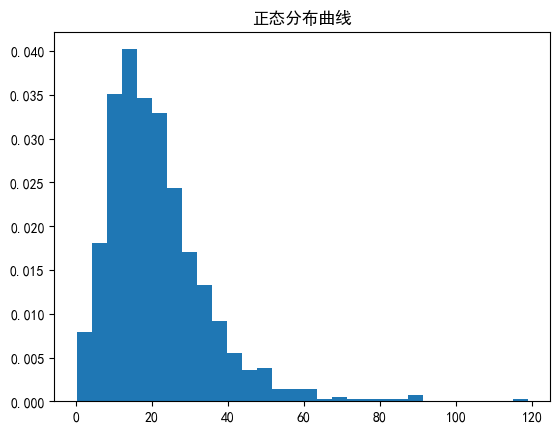

NormaltestResult(statistic=794.0986070155933, pvalue=3.66166360187042e-173)


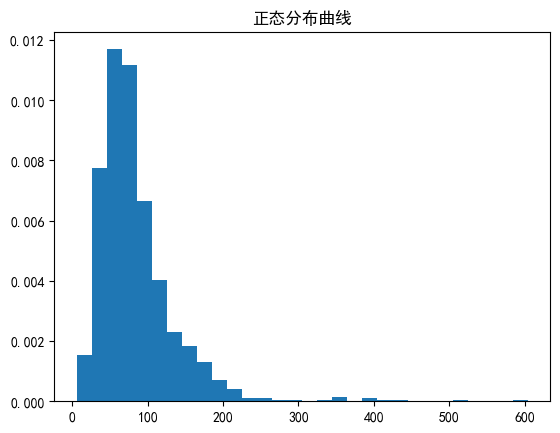

NormaltestResult(statistic=760.2418873861434, pvalue=8.233257496235973e-166)


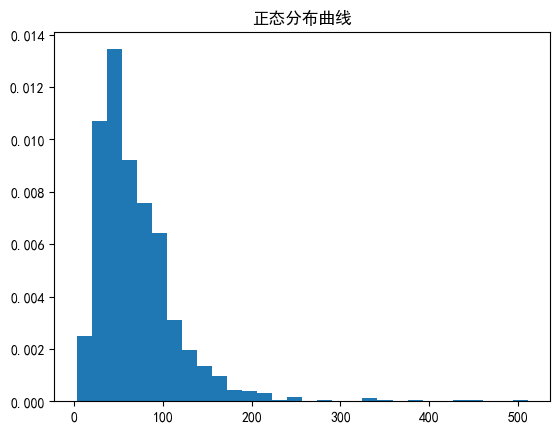

In [28]:
df_list=[anthophyllum,cauliflower,tubers,eggplant,capsicum,mushroom]
i=0
for df in df_list:
    df['销售日期'] = pd.to_datetime(df['销售日期'])
    df = df.groupby('销售日期')['销量(千克)'].sum().reset_index()
    # 创建新的数据框（只销售日期列和销量(千克)列）
    df = pd.DataFrame({'销售日期': df['销售日期'], '销量(千克)': df['销量(千克)']})
    # 对数据框按照 '销售日期' 列进行排序
    df = df.sort_values(by='销售日期')
    df=df.reset_index(drop=True)
    df_list[i]=df
    # 计算均值
    mu = np.mean(df['销量(千克)'])

    # 计算标准差
    sigma = np.std(df['销量(千克)'])
    print(stats.normaltest(df['销量(千克)']))#检验序列是否为正态分布    <  0.05  拒绝原假设 认为残差符合正态分布
    # 绘制直方图
    count, bins, ignored = plt.hist(df['销量(千克)'],30, density=True)
    plt.title('正态分布曲线')
    plt.show()
    i=i+1


In [30]:
df_list[0]

,销售日期,销量(千克)
0,2020-07-01,205.402
1,2020-07-02,198.362
2,2020-07-03,190.779
3,2020-07-04,236.587
4,2020-07-05,223.899
...,...,...
1080,2023-06-26,80.524
1081,2023-06-27,127.278
1082,2023-06-28,130.182
1083,2023-06-29,135.090


In [35]:
from functools import reduce

# 假设这些是你的数据框列表
merged_df1 = pd.merge(df_list[0], df_list[1], on='销售日期', how='inner')
merged_df2 = pd.merge(df_list[2], df_list[3], on='销售日期', how='inner')
merged_df3 = pd.merge(df_list[4], df_list[5], on='销售日期', how='inner')
merged_df4 = pd.merge(merged_df1, merged_df2, on='销售日期', how='inner')
merged_df = pd.merge(merged_df3, merged_df4, on='销售日期', how='inner')
new_columns = {
    '销售日期': '销售日期',
    '销量(千克)_x': '花叶类销量(千克)',
    '销量(千克)_y': '花菜类销量(千克)',
    '销量(千克)_x_x': '水生根茎类销量(千克)',
    '销量(千克)_y_x': '茄类销量(千克)',
    '销量(千克)_x_y': '辣椒类销量(千克)',
    '销量(千克)_y_y': '食用菌类销量(千克)'
}

# 使用 rename 方法修改列名
merged_df = merged_df.rename(columns=new_columns)
# 提取感兴趣的列，例如，花叶类销量(千克)、花菜类销量(千克)等
interested_columns = ["花叶类销量(千克)", "花菜类销量(千克)", "水生根茎类销量(千克)", "茄类销量(千克)", "辣椒类销量(千克)", "食用菌类销量(千克)"]
 
# 选择感兴趣的列构建新的DataFrame
selected_df = merged_df[interested_columns]
selected_df
merged_df

,销售日期,花叶类销量(千克),花菜类销量(千克),水生根茎类销量(千克),茄类销量(千克),辣椒类销量(千克),食用菌类销量(千克)
0,2020-07-01,76.715,35.365,205.402,46.640,4.850,35.374
1,2020-07-02,66.064,48.510,198.362,43.943,4.600,32.199
2,2020-07-03,64.253,42.442,190.779,42.076,9.572,35.896
3,2020-07-04,81.282,47.262,236.587,55.662,5.439,57.067
4,2020-07-05,98.496,73.213,223.899,55.474,4.019,61.816
...,...,...,...,...,...,...,...
1044,2023-06-26,72.185,39.582,80.524,8.083,10.384,21.224
1045,2023-06-27,67.120,38.708,127.278,14.272,16.454,8.415
1046,2023-06-28,68.534,53.742,130.182,16.069,14.946,15.651
1047,2023-06-29,89.113,48.314,135.090,24.367,22.945,11.511


Pearson Correlation Coefficient Matrix:
             花叶类销量(千克)  花菜类销量(千克)  水生根茎类销量(千克)  茄类销量(千克)  辣椒类销量(千克)  \
花叶类销量(千克)     1.000000   0.686002     0.652635  0.544262   0.610252   
花菜类销量(千克)     0.686002   1.000000     0.630380  0.519611   0.670317   
水生根茎类销量(千克)   0.652635   0.630380     1.000000  0.622311   0.555334   
茄类销量(千克)      0.544262   0.519611     0.622311  1.000000   0.541717   
辣椒类销量(千克)     0.610252   0.670317     0.555334  0.541717   1.000000   
食用菌类销量(千克)    0.317525   0.140319     0.322177  0.347625   0.105562   

             食用菌类销量(千克)  
花叶类销量(千克)      0.317525  
花菜类销量(千克)      0.140319  
水生根茎类销量(千克)    0.322177  
茄类销量(千克)       0.347625  
辣椒类销量(千克)      0.105562  
食用菌类销量(千克)     1.000000  


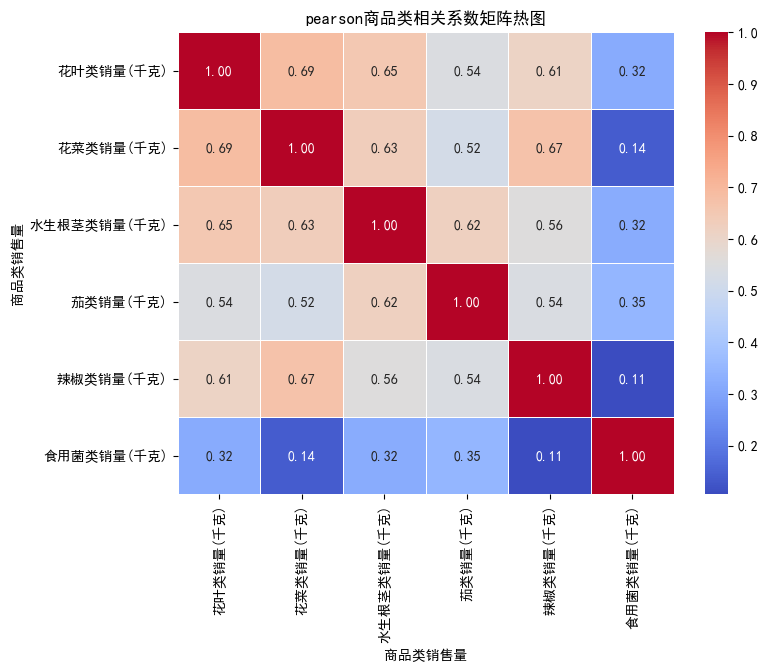

In [36]:
# 计算时间序列之间的皮尔逊相关系数
correlation_matrix = selected_df.corr()

# 打印相关系数矩阵
print("Pearson Correlation Coefficient Matrix:")
print(correlation_matrix)
# 假设你的数据名为 correlation_matrix
# 使用热图可视化相关系数矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('pearson商品类相关系数矩阵热图')
plt.xlabel('商品类销售量')
plt.ylabel('商品类销售量')
plt.show()


Spearman Correlation Coefficient Matrix:
[[ 1.          0.52383154  0.58405337  0.41628436  0.31499464  0.15324004]
 [ 0.52383154  1.          0.590556    0.45648264  0.60134438 -0.09121655]
 [ 0.58405337  0.590556    1.          0.62525823  0.42964114  0.32493824]
 [ 0.41628436  0.45648264  0.62525823  1.          0.3883332   0.23488409]
 [ 0.31499464  0.60134438  0.42964114  0.3883332   1.         -0.19358667]
 [ 0.15324004 -0.09121655  0.32493824  0.23488409 -0.19358667  1.        ]]


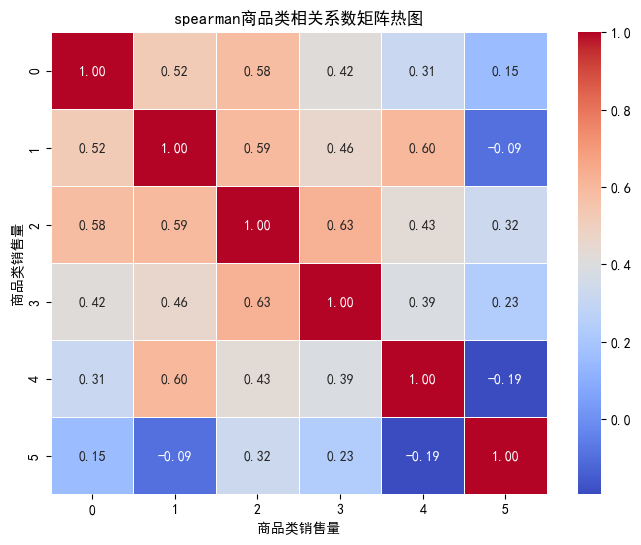

In [37]:
# 计算时间序列之间的spearman相关系数
spearman_corr_matrix, _ = spearmanr(selected_df)
# 打印spearman相关系数矩阵
print("Spearman Correlation Coefficient Matrix:")
print(spearman_corr_matrix)
# 假设你的数据名为 spearman_corr_matrix
# 使用热图可视化相关系数矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('spearman商品类相关系数矩阵热图')
plt.xlabel('商品类销售量')
plt.ylabel('商品类销售量')
plt.show()